<a href="https://colab.research.google.com/github/sayarghoshroy/relevance-paradox/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import sys
from tqdm import tqdm

In [ ]:
filename = 'drive/My Drive/summworth/cleaned_document.json'

with open(filename, 'r+') as f:
  sent_scores = json.load(f)

In [ ]:
# Grounding Spacy's Transformer Models
!pip install -U spacy
import spacy

!pip install spacy-transformers

!python -m spacy download en
!python -m spacy download en_trf_bertbaseuncased_lg

In [ ]:
# Loading Spacy's BERT Model

nlp = spacy.load(path + '/en_trf_bertbaseuncased_lg')

In [ ]:
def clean(txt):
  txt = txt.replace("\n", " ").replace("\r", " ")
  punc_list = '!"#$&*+,-./;?@\^_~)('
  t = str.maketrans(dict.fromkeys(punc_list, " "))
  txt = txt.translate(t)
  t = str.maketrans(dict.fromkeys("'`", ""))
  txt = txt.translate(t)

  return txt

def regtok(txt):
  txt = clean(txt)
  regex = re.compile(r'(\d+|\s+|=|}}|\|)')
  tokens = [token for token in regex.split(txt)]
  return tokens

In [ ]:
limit = len([key for key in sent_scores.keys()])
print("Number of Documents: " + str(limit))

Number of Documents: 81393


In [ ]:
lengths = []
scores = []
similarity_scores = []

# Run test for a Specific Number of Documents
limit = 1000

for key in tqdm(sent_scores.keys(), total = limit):
    doc = sent_scores[key]['sent_labels']
    sent_embs = []
    doc_emb = 0
    full_sequence = ""
    
    for unit in doc:
      if len(unit) != 3:
          # Missing Parameters
          continue
      try:
          if unit[2] == 1:
              # checking if it is a grammatical sentence
              temp_score = float(unit[1])
              temp_length = int(len(regtok(unit[0])))
              semantic_vec = nlp(unit[0])

              if temp_score > -1 and temp_score < 10:
                  scores.append(temp_score)
                  lengths.append(temp_length)
                  sent_embs.append(semantic_vec)
                  full_sequence = full_sequence + unit[0] + " "

      except Exception as e:
         continue

    doc_emp = nlp(full_sequence)
    for emb in sent_embs:
        similarity_scores.append(doc_emb.similarity(emb))

100%|██████████| 81393/81393 [00:00<00:00, 106930.14it/s]


In [ ]:
assert len(lengths) == len(scores)
assert len(lengths) == len(similarity_scores)
print("Number of Data Points: " + str(len(lengths)))

Number of Data Points: 33564


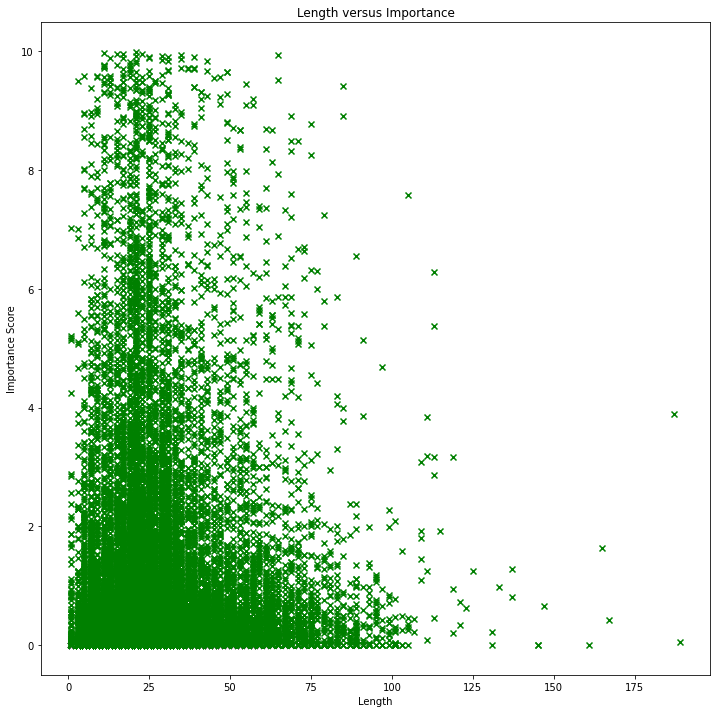

In [ ]:
# Study against Length
fig = plt.figure(figsize = (12, 12))
p = fig.add_subplot('111')
p.set_title('Length versus Importance')
p.set_xlabel('Length')
p.set_ylabel('Importance Score')
p.scatter(lengths, scores, color = 'green', marker = 'x')
plt.show()

In [ ]:
# ^_^ Thank You